In [9]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import pytensor
import pytensor.tensor as pt
import pymc.sampling_jax
import numpyro
import blackjax
import jax
from sklearn.preprocessing import StandardScaler

import arviz as az

settings = {'figure.figsize':(14,4),
            'figure.dpi':144,
            'figure.facecolor':'w',
            'axes.spines.top':False,
            'axes.spines.bottom':False,
            'axes.spines.left':False,
            'axes.spines.right':False,
            'axes.grid':True,
            'grid.linestyle':'--',
            'grid.linewidth':0.5}
plt.rcParams.update(settings)

SEED = sum(map(ord, 'Forcasting in PyMC'))
rng = np.random.default_rng(SEED)

In [10]:
def plot_results(idata, test_data=None, oos_name='Test'):
    groups = ['posterior_predictive', 'predictions', 'observed_data']
    colors = ['tab:blue', 'tab:orange', 'tab:red']
    labels = ['Training', oos_name, 'Data']
    fig, ax = plt.subplots()
    
    time_dim_name = list(idata.observed_data.dims.keys())[0]
    x_train = idata.observed_data.coords[time_dim_name]
    
    H = list(idata.predictions.dims.values())[-1]
    x_test = np.arange(x_train[-1], x_train[-1] + H)
    
    x_values = [x_train, x_test, x_train]
    
    for group, color, label, x_val in zip(groups, colors, labels, x_values):
        data = getattr(idata, group).y_hat
        
        if group == 'observed_data':
            ax.plot(x_val, data, c=color, label=label)
            continue
            
        hdi = az.hdi(data).y_hat
        ax.plot(x_val, data.mean(dim=['chain', 'draw']), label=label)
        ax.fill_between(x_val, *hdi.values.T, color=color, alpha=0.25)
    if test_data is not None:
        ax.plot(x_test, test_data, color='tab:red')
    ax.legend()
    plt.show()

### Non-Recursive Deterministic Trend

In [11]:
data = pd.read_csv(r"data/a0_combinedQuarterly_new.csv", index_col=[0])
data = data['gdp_total_season'].to_frame()

scaler = StandardScaler()
data = scaler.fit_transform(data)

T = data.shape[0]
t = np.arange(T)

$
y_t = \alpha + \gamma t + \epsilon_t 
$

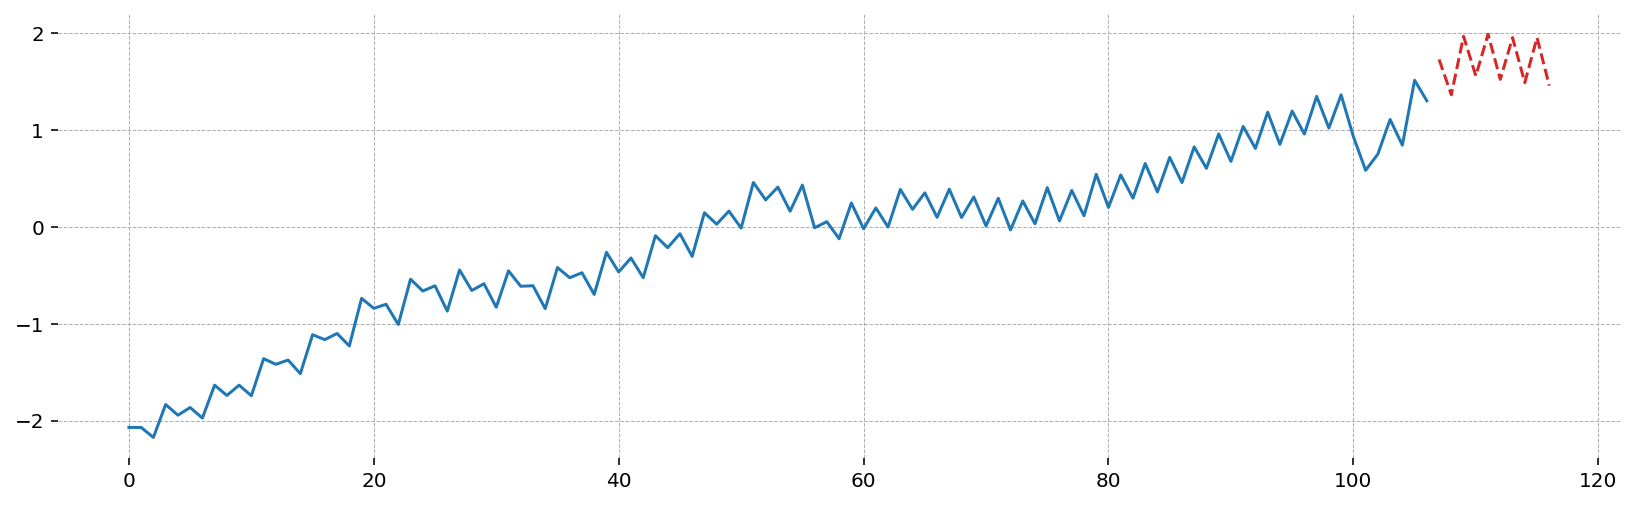

In [12]:

train_data = data[:107]
test_data = data[-10:]

plt.plot(train_data, color='tab:blue')
plt.plot(np.arange(107, 117), test_data, ls='--', color='tab:red')


In [25]:
with pm.Model() as det_trend:
    t_pt = pm.MutableData('t', t[:107])
    alpha = pm.Normal('alpha')
    gamma = pm.Normal('gamma')
    
    mu = pm.Deterministic('mu', alpha + gamma * t_pt)
    sigma = pm.Exponential('sigma', 1)
    
    y_hat = pm.StudentT('y_hat', mu=mu, nu=5, sigma=sigma, observed=train_data.flatten(), shape=t_pt.shape)
    idata = pm.sample()

/home/jpp/miniconda3/envs/pymc_env/lib/python3.12/site-packages/pymc/data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, gamma, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [26]:

with det_trend:
    #in-sample 
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)
    
    #out-of-sample
    pm.set_data({'t':t[-10:]})
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True, predictions=True)

Sampling: [y_hat]


Output()

Sampling: [y_hat]


Output()

/tmp/ipykernel_28717/2490698906.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  time_dim_name = list(idata.observed_data.dims.keys())[0]
/tmp/ipykernel_28717/2490698906.py:10: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  H = list(idata.predictions.dims.values())[-1]
<frozen _collections_abc>:913: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


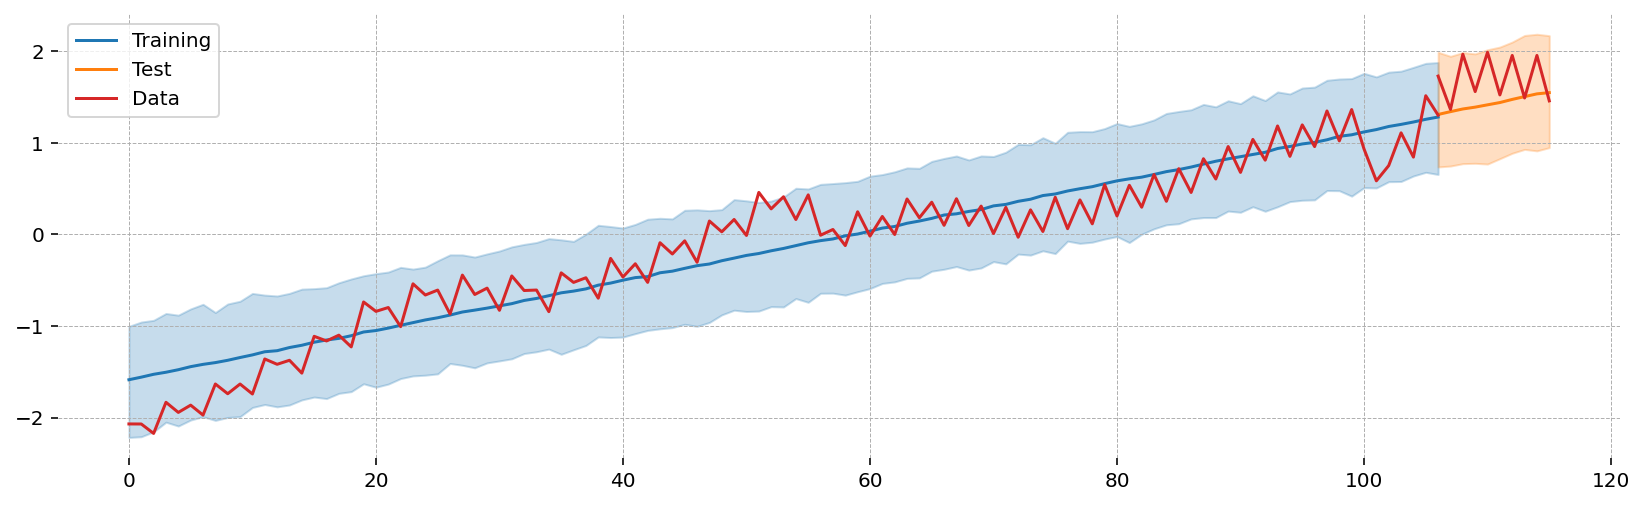

In [27]:
plot_results(idata, test_data)

### Prophet

In [28]:
data = pd.read_csv(r"data/a0_combinedQuarterly_new.csv", index_col=[0])
df = data['gdp_total_season'].to_frame()

# Center and scale the data
df['gdp_total_season'] = df['gdp_total_season'].transform(lambda x: (x - x.mean()) / x.std())

In [29]:
def create_piecewise_trend(t, t_max, n_changepoints):    
    s = pt.linspace(0, t_max, n_changepoints+2)[1:-1]
    A = (t[:, None] > s)*1
    return A, s

def create_fourier_features(t, n, p=365.25):
    x = 2 * np.pi * (pt.arange(n)+1) * t[:, None] / p
    return pt.concatenate((pt.cos(x), pt.sin(x)), axis = 1)

def generate_features(t, t_max, n_changepoints=10, n_fourier=6, p=365.25):
    A, s = create_piecewise_trend(t, t_max, n_changepoints)
    X = create_fourier_features(t, n_fourier, p)
    
    return A, s, X

In [33]:
t = np.arange(df.shape[0])
t_max = max(t)
with pm.Model() as prophet_model:
    t_pt = pm.MutableData('t', t)
    A, s, X = generate_features(t_pt, t_max, n_changepoints=10, n_fourier=6, p=4)
    
    initial_slope = pm.Normal('initial_slope')
    initial_intercept = pm.Normal('initial_intercept')
    
    # n_changepoint offsets terms to build the peicewise trend
    deltas = pm.Normal('offset_delta', shape=(10,))
        
    intercept = initial_intercept + ((-s * A) * deltas).sum(axis=1)
    slope = initial_slope + (A * deltas).sum(axis=1)
    
    # n_fourier * 2 seasonal coefficients
    beta = pm.Normal('beta', size=12)
    
    mu = pm.Deterministic('mu', intercept + slope * t_pt + X @ beta)
    sigma = pm.Exponential('sigma', 1)
    y_hat = pm.StudentT('y_hat', mu=mu, nu = 3, sigma=sigma, observed=df.values.ravel(), shape=t_pt.shape)
    
    idata = pymc.sampling_jax.sample_numpyro_nuts()

/home/jpp/miniconda3/envs/pymc_env/lib/python3.12/site-packages/pymc/data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2024-09-04 13:31:38.848823: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 8s:

  %reduce = f64[4,1000,117,10]{3,2,1,0} reduce(f64[4,1000,1,117,10]{4,3,2,1,0} %broadcast.47, f64[] %constant.9), dimensions={2}, to_apply=%region_1.50, metadata={op_name="jit(process_fn)/jit(main)/reduce_prod[axes=(2,)]" source_file="/tmp/tmpocmw4oc6" source_line=23}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-09-04 13:32:06.410682: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 35.561950667s
Constant folding an instruction is taking > 8s:

  %reduce = f64[4,1000,117,10]{3

In [34]:
with prophet_model:
    #in-sample 
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)
    
    #out-of-sample
    last_t = t[-1]
    
    # Forcast 3 years of home sales
    forcast_t = np.arange(last_t, last_t + 12)
    pm.set_data({'t':forcast_t})
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True, predictions=True)

Sampling: [y_hat]


Output()

Sampling: [y_hat]


Output()

/tmp/ipykernel_28717/2490698906.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  time_dim_name = list(idata.observed_data.dims.keys())[0]
/tmp/ipykernel_28717/2490698906.py:10: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  H = list(idata.predictions.dims.values())[-1]
<frozen _collections_abc>:913: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


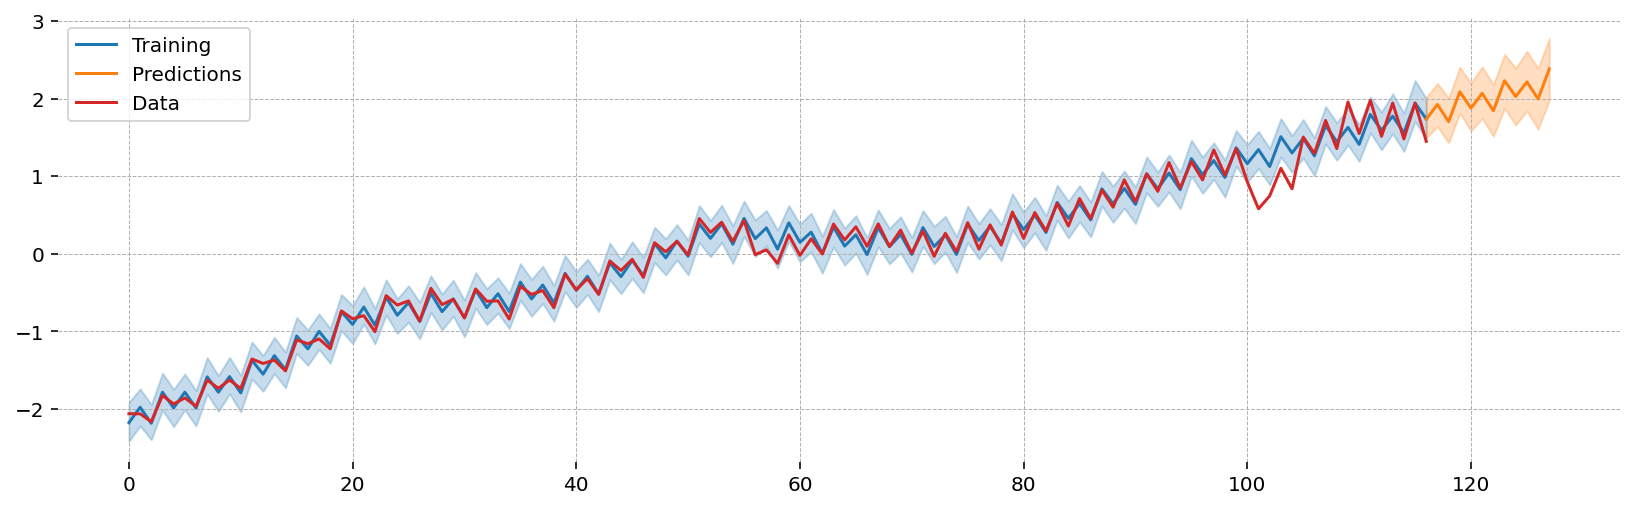

In [35]:
plot_results(idata, oos_name='Predictions')